In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
import scipy.io as sio
import math

(1958, 784) (1991, 784) (1958,) (1991,)


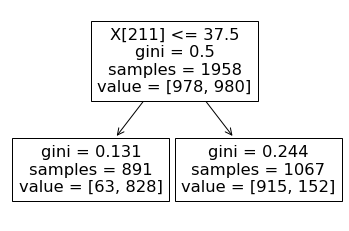

In [27]:
"""
data = sio.loadmat('mnist.mat')


Xtrain = data['trainX'][:10000,:].astype(int)
Xtest = data['testX'].astype(int)
ytrain =data['trainY'][0,:10000].astype(int)
ytest =  data['testY'][0,:].astype(int)

idx = np.logical_or(np.equal(ytrain,4), np.equal(ytrain,9))
Xtrain = Xtrain[idx,:]
ytrain = ytrain[idx]
ytrain[np.equal(ytrain,4)] = 1
ytrain[np.equal(ytrain,9)] = -1

idx = np.logical_or(np.equal(ytest,4), np.equal(ytest,9))
Xtest = Xtest[idx,:]
ytest = ytest[idx]
ytest[np.equal(ytest,4)] = 1
ytest[np.equal(ytest,9)] = -1


sio.savemat('mnist_binary_small.mat',{'Xtrain':Xtrain,'ytrain':ytrain,'Xtest':Xtest,'ytest':ytest})
"""

data = sio.loadmat('mnist_binary_small.mat')
Xtrain = data['Xtrain']
Xtest = data['Xtest']
ytrain = data['ytrain'][0,:]
ytest = data['ytest'][0,:]

print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

clf = tree.DecisionTreeClassifier(random_state=0, max_depth = 1)
clf.fit(Xtrain, ytrain)
tree.plot_tree(clf)
plt.show()

In [31]:

def get_weighted_misclass(w,y,yhat):
    total = 0
    for i in range(len(y)):
        if(y[i]!=yhat[i]):
            total+=w[i]
    
    return total

def get_misclass(y,yhat):
    count = 0
    for i in range(len(y)):
        if(y[i] != yhat[i]):
            count+=1
    return (count / len(y))*100


def get_exp_loss(y,yhat):
    total = 0
    for i in range(len(y)):
        total+= math.exp(-1*y[i]*yhat[i])
    return (total/ len(y))

train_misclass = get_misclass(ytrain, clf.predict(Xtrain))
test_misclass = get_misclass(ytest, clf.predict(Xtest))
exp_loss = get_exp_loss(ytrain, clf.predict(Xtrain))
print("",train_misclass, "% train misclassification,\n", test_misclass, "% test misclassification,\n", exp_loss, "exponential loss")

 0.0 % train misclassification,
 5.675539929683576 % test misclassification,
 0.36787944117145105 exponential loss


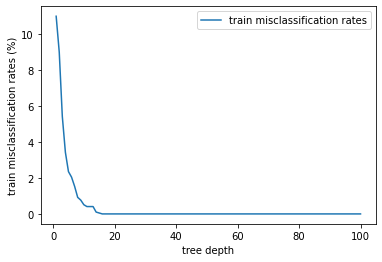

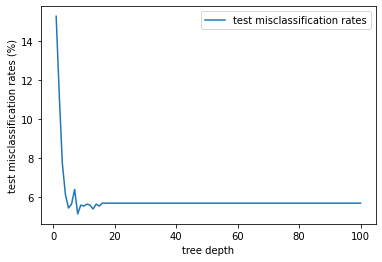

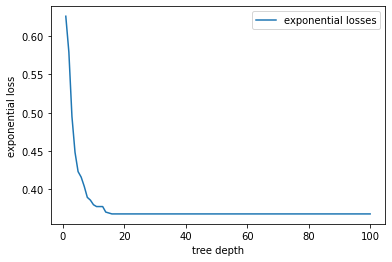

min train classification rate: 0.0 %
min test classification rate: 5.123053741838272 %
min exponential loss: 0.36787944117145105


In [29]:
train_rates = [] 
test_rates = []
exp_losses = []
depths = range(1,101)

for i in depths:
    clf = tree.DecisionTreeClassifier(random_state=0, max_depth = i)
    clf.fit(Xtrain, ytrain)
    train_rates.append(get_misclass(ytrain, clf.predict(Xtrain)))
    test_rates.append(get_misclass(ytest, clf.predict(Xtest)))
    exp_losses.append(get_exp_loss(ytrain, clf.predict(Xtrain)))

plt.plot(depths, train_rates, label="train misclassification rates")
plt.xlabel("tree depth")
plt.ylabel("train misclassification rates (%)")
plt.legend()
plt.show()

plt.plot(depths, test_rates, label="test misclassification rates")
plt.ylabel("test misclassification rates (%)")
plt.xlabel("tree depth")
plt.legend()
plt.show()

plt.plot(depths, exp_losses, label="exponential losses")
plt.ylabel("exponential loss")
plt.xlabel("tree depth")
plt.legend()
plt.show()

print("min train classification rate:", min(train_rates),"%")
print("min test classification rate:", min(test_rates),"%")
print("min exponential loss:", min(exp_losses))


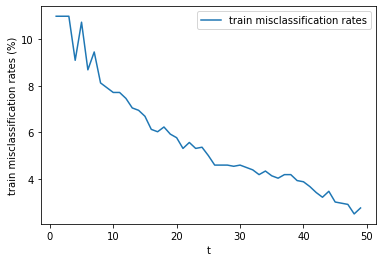

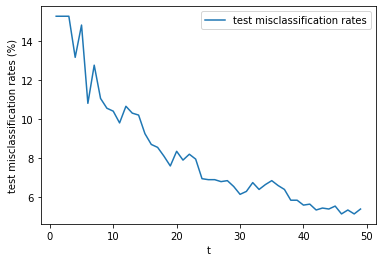

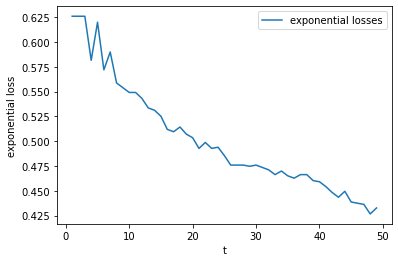

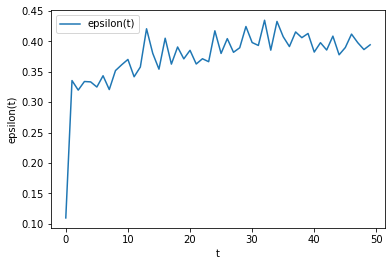

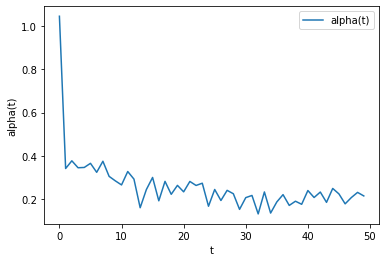

min train classification rate: 2.502553626149132 %
min test classification rate: 5.123053741838272 %
min exponential loss: 0.4266995213436124


In [49]:


class AdaBoost:
    def __init__(self, T, Xtrain, ytrain):
        w = np.ones(len(ytrain))
        w /= len(ytrain)
        self.T = T
        self.clf = [] #tree
        self.alphas = [] #amount of say
        self.epsilons = []
        for t in range(T):
            self.clf.append(tree.DecisionTreeClassifier(random_state=0, max_depth = 1))
            self.clf[t] = self.clf[t].fit(Xtrain, ytrain, sample_weight = w)

            train_misclass = get_weighted_misclass(w, ytrain, self.clf[t].predict(Xtrain))
            self.alphas.append(0.5 * math.log((1-train_misclass)/train_misclass))
            
            self.epsilons.append(0)
            for i in range(len(ytrain)):
                if(ytrain[i] != self.clf[t].predict([Xtrain[i]])[0]):
                    self.epsilons[t] += w[i]
                    w[i] *= math.exp(self.alphas[t])
                else:
                    w[i] *= math.exp(-1 * self.alphas[t] )
            w /= np.sum(w)
    def predict(self,Xtest,T):
        if(T > self.T):
            T = self.T
        yhat = np.zeros(len(Xtest))
        for x in range(len(Xtest)):
            y_vals = []
            y_count = []
            for i in range(T):
                prediction = self.clf[i].predict([Xtest[x]])[0]
                if(prediction in y_vals):
                    y_count[y_vals.index(prediction)] += self.alphas[i]
                else:
                    y_vals.append(prediction)
                    y_count.append(self.alphas[i])
            yhat[x] = y_vals[y_count.index(max(y_count))]
        return yhat
    def plot(self):
        train_rates = []
        test_rates = []
        exp_losses = []
        for t in range(1, self.T):
            train_rates.append(get_misclass(ytrain, adaboost.predict(Xtrain, t)))
            test_rates.append(get_misclass(ytest, adaboost.predict(Xtest,t)))
            exp_losses.append(get_exp_loss(ytrain, adaboost.predict(Xtrain,t)))
        
        plt.plot(range(1, self.T), train_rates, label="train misclassification rates")
        plt.xlabel("t")
        plt.ylabel("train misclassification rates (%)")
        plt.legend()
        plt.show()

        plt.plot(range(1,self.T), test_rates, label="test misclassification rates")
        plt.ylabel("test misclassification rates (%)")
        plt.xlabel("t")
        plt.legend()
        plt.show()

        plt.plot(range(1,self.T), exp_losses, label="exponential losses")
        plt.ylabel("exponential loss")
        plt.xlabel("t")
        plt.legend()
        plt.show()
        
        plt.plot(range(self.T), self.epsilons, label="epsilon(t)")
        plt.ylabel("epsilon(t)")
        plt.xlabel("t")
        plt.legend()
        plt.show()

        plt.plot(range(self.T), self.alphas, label="alpha(t)")
        plt.ylabel("alpha(t)")
        plt.xlabel("t")
        plt.legend()
        plt.show()
        
        print("min train classification rate:", min(train_rates),"%")
        print("min test classification rate:", min(test_rates),"%")
        print("min exponential loss:", min(exp_losses))
adaboost = AdaBoost(50, Xtrain, ytrain)


# train_misclass = get_misclass(ytrain, adaboost.predict(Xtrain))
# test_misclass = get_misclass(ytest, adaboost.predict(Xtest))
# exp_loss = get_exp_loss(ytrain, adaboost.predict(Xtrain))
# print("",train_misclass, "% train misclassification,\n", test_misclass, "% test misclassification,\n", exp_loss, "exponential loss")

adaboost.plot()